<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Why-is-gradient-descent-so-bad-at-optimizing-polynomial-regression?" data-toc-modified-id="Why-is-gradient-descent-so-bad-at-optimizing-polynomial-regression?-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Why is gradient descent so bad at optimizing polynomial regression?</a></span></li><li><span><a href="#Polynomial-regression" data-toc-modified-id="Polynomial-regression-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Polynomial regression</a></span></li></ul></li><li><span><a href="#:-Comparing-results-for-high-order-polynomial-regression" data-toc-modified-id=":-Comparing-results-for-high-order-polynomial-regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>: Comparing results for high order polynomial regression</a></span></li><li><span><a href="#:-Repeating-the-experiment-with-2-polynomial-variables-and-visualizing-the-results" data-toc-modified-id=":-Repeating-the-experiment-with-2-polynomial-variables-and-visualizing-the-results-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>: Repeating the experiment with 2 polynomial variables and visualizing the results</a></span></li></ul></div>

## Why is gradient descent so bad at optimizing polynomial regression?# 

Question from Stackexchange:
https://stats.stackexchange.com/questions/350130/why-is-gradient-descent-so-bad-at-optimizing-polynomial-regression




### Linear regression

#### Cost function
$J(\theta) = \frac{1}{2m}\sum_{i=1}^m(h_\theta(x^{(i)}) - y^{(i)})^2 $

$J(\theta) = \frac{1}{2m}(X\theta - y)^T(X\theta - y) $ (vectorized version)

#### Gradient 
$\frac{\partial J(\theta)}{\partial \theta} = \frac{1}{m}X^T(X\theta - y) $ 

##### Hessian
$\frac{\partial^2 J(\theta)}{\partial \theta^2} = \frac{1}{m}X^T X $ 

## Polynomial regression
The design matrix is of the form: 

$ \mathbf{X = [1 , x , x^2 , x^3 , ... , x}^n]$

### Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
from sklearn import linear_model
import statsmodels.api as sm

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('seaborn-white')

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Helper Functions 

In [2]:
def costfunction(theta,X,y):
    m = np.size(y)
    theta = theta.reshape(-1,1)
    
    #Cost function in vectorized form
    h = X @ theta
    J = float((1./(2*m)) * (h - y).T @ (h - y));    
    return J;

def gradient_descent(theta,X,y,alpha = 0.0005,num_iters=1000):
    m = np.size(y)
    J_history = np.empty(num_iters)
    count_history = np.empty(num_iters)
    theta_1_hist, theta_2_hist = [], []
    
    for i in range(num_iters):
        #Grad function in vectorized form
        h = X @ theta
        theta = theta - alpha * (1/m)* (X.T @ (h-y))
        
        #Tracker values for plotting
        J_history[i] = costfunction(theta,X,y)
        count_history[i] = i
        theta_1_hist.append(theta[0,0])
        theta_2_hist.append(theta[1,0])
        
    return theta, J_history,count_history, theta_1_hist, theta_2_hist

def grad(theta,X,y):
    #Initializations
    theta = theta[:,np.newaxis]
    m = len(y)
    grad = np.zeros(theta.shape)
    
    #Computations
    h = X @ theta
    
    grad = (1./m)*(X.T @ ( h - y))
    
    return (grad.flatten())


def polynomial_features(data, deg):
    data_copy=data.copy()
    
    for i in range(1,deg):
        data_copy['X'+str(i+1)]=data_copy['X'+str(i)]*data_copy['X1']

    return data_copy

def hessian(theta,X,y):
    m,n = X.shape
    X = X.values
    return ((1./m)*(X.T @ X))

# : Comparing results for high order polynomial regression 

### Initializing the data

In [3]:
#Create data from sin function with uniform noise
x = np.linspace(0.1,1,40)
noise = np.random.uniform(  size = 40)
y = np.sin(x * 1.5 * np.pi ) 
y_noise = (y + noise).reshape(-1,1)
y_noise = y_noise - y_noise.mean() #Centering the data

degree = 7
X_d = polynomial_features(pd.DataFrame({'X0':1,'X1': x}),degree)

### Closed form solution 

In [4]:
def closed_form_solution(X,y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

coefs = closed_form_solution(X_d.values,y_noise)
coefs

array([[-2.95437720e+00],
       [ 6.50561451e+01],
       [-5.29277649e+02],
       [ 2.29876198e+03],
       [-5.44238666e+03],
       [ 6.98373410e+03],
       [-4.56867395e+03],
       [ 1.19415965e+03]])

### Numpy only fit

In [5]:
stepsize = .1
theta_result_1,J_history_1, count_history_1, theta_1_hist, theta_2_hist = gradient_descent(np.zeros((len(X_d.T),1)).reshape(-1,1), X_d,y_noise,alpha = stepsize,num_iters=5000)
display(theta_result_1)

array([[ 0.46548572],
       [ 1.24606966],
       [-1.36884742],
       [-1.79417815],
       [-1.19320446],
       [-0.36286233],
       [ 0.39300774],
       [ 0.99476541]])

### Sciy optimize fit using first order derivative only
#### Comment: BFGS does very well but requires adjustment of options
In particular tolerance must be made smaller as the cost function is very flat near the global minimum

In [6]:
import scipy.optimize as opt

theta_init = np.ones((len(X_d.T),1)).reshape(-1,1)
model_t = opt.minimize(fun = costfunction, x0 = theta_init , args = (X_d, y_noise), 
                             method = 'BFGS', jac = grad, options={'maxiter':1000, 'gtol': 1e-10, 'disp' : True})
model_t.x

Optimization terminated successfully.
         Current function value: 0.036158
         Iterations: 152
         Function evaluations: 156
         Gradient evaluations: 156


array([-2.95437890e+00,  6.50561760e+01, -5.29277889e+02,  2.29876294e+03,
       -5.44238875e+03,  6.98373664e+03, -4.56867556e+03,  1.19416006e+03])

### Sciy optimize fit using hessian matrix
#### As expected, 2nd order information allows to converge much faster

In [7]:
import scipy.optimize as opt

theta_init = np.ones((len(X_d.T),1)).reshape(-1,1)
model_t = opt.minimize(fun = costfunction, x0 = theta_init , args = (X_d, y_noise), 
                             method = 'dogleg', jac = grad, hess= hessian, options={'maxiter':1000, 'disp':True})
model_t.x


Optimization terminated successfully.
         Current function value: 0.036158
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
         Hessian evaluations: 20


array([-2.95437904e+00,  6.50561791e+01, -5.29277914e+02,  2.29876304e+03,
       -5.44238897e+03,  6.98373692e+03, -4.56867574e+03,  1.19416011e+03])

### Sklearn fit 

In [8]:
from sklearn import linear_model
model_d = linear_model.LinearRegression(fit_intercept=False)
model_d.fit(X_d,y_noise)
model_d.coef_

array([[-2.95437904e+00,  6.50561790e+01, -5.29277914e+02,
         2.29876304e+03, -5.44238897e+03,  6.98373691e+03,
        -4.56867573e+03,  1.19416011e+03]])

### Statsmodel fit 

In [9]:
import statsmodels.api as sm
model_sm = sm.OLS(y_noise, X_d)
res = model_sm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     37.49
Date:                Thu, 07 Jun 2018   Prob (F-statistic):           1.16e-13
Time:                        10:21:12   Log-Likelihood:                -4.2236
No. Observations:                  40   AIC:                             24.45
Df Residuals:                      32   BIC:                             37.96
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X0            -2.9544      4.220     -0.700      0.4

# : Repeating the experiment with 2 polynomial variables and visualizing the results
Here we will focus on a 2-D design matrix with $x$ and $x^2$ values. The y values have been centered so we will ignore the constant term and y-intercept

### Initializing the data

In [10]:
#Create data from sin function with uniform noise
x = np.linspace(0.1,1,40) #Adjusting the starting point to reduce numerical instability
noise = np.random.uniform(  size = 40)
y = np.sin(x * 1.5 * np.pi ) 
y_noise = (y + noise).reshape(-1,1)
y_noise = y_noise - y_noise.mean() #Centering the data

#2nd order polynomial only
degree = 2
X_d = polynomial_features(pd.DataFrame({'X1': x}),degree)

#Starting point for gradient descent - see later diagrams
initial_theta = np.array([0,-2]).reshape(-1,1)

In [11]:
X_d = X_d[['X1','X2']]
X_d.head()

,X1,X2
0,0.100000,0.010000
1,0.123077,0.015148
2,0.146154,0.021361
3,0.169231,0.028639
4,0.192308,0.036982


### Closed form solution 

In [12]:
def closed_form_solution(X,y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

coefs = closed_form_solution(X_d.values,y_noise)
coefs

array([[ 3.62016596],
       [-5.38895073]])

### Numpy only fit

In [14]:
stepsize = .3
theta_result,J_history, count_history_1, theta_1, theta_2 = gradient_descent(initial_theta,X_d,y_noise,alpha = stepsize,num_iters=10000)
display(theta_result)

array([[ 3.62016596],
       [-5.38895073]])

### Plotting the gradient descent convergence and resulting fits 

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


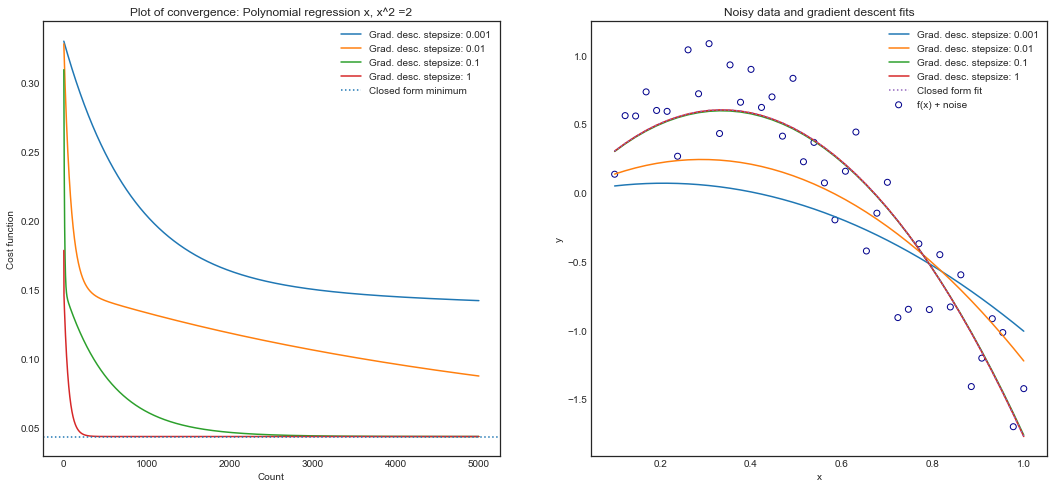

In [15]:
fig = plt.figure(figsize = (18,8))

#Looping through different stepsizes
for s in [.001,.01,.1,1]:
    theta_calc,J_history_1, count_history_1, theta_1, theta_2 = gradient_descent(initial_theta, X_d,y_noise,alpha = s,num_iters=5000)
    
    #Plot gradient descent convergence
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(count_history_1, J_history_1, label = 'Grad. desc. stepsize: {}'.format(s))

    #Plot resulting fits on data
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x,X_d@theta_calc, label = 'Grad. desc. stepsize: {}'.format(s))
    
#Adding plot features
ax = fig.add_subplot(1, 2, 1)
ax.axhline(costfunction(coefs, X_d, y_noise), linestyle=':', label = 'Closed form minimum')
ax.set_xlabel('Count')
ax.set_ylabel('Cost function')
ax.set_title('Plot of convergence: Polynomial regression x, x^2 ={}'.format(degree))
ax.legend(loc = 1)

ax = fig.add_subplot(1, 2, 2)
ax.scatter(x,y_noise, facecolors = 'none', edgecolor = 'darkblue', label = 'f(x) + noise')
ax.plot(x,X_d@coefs, linestyle=':', label = 'Closed form fit')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Noisy data and gradient descent fits'.format(degree))
ax.legend()

plt.show()

### Plotting the cost function in 3D 

No handles with labels found to put in legend.
No handles with labels found to put in legend.


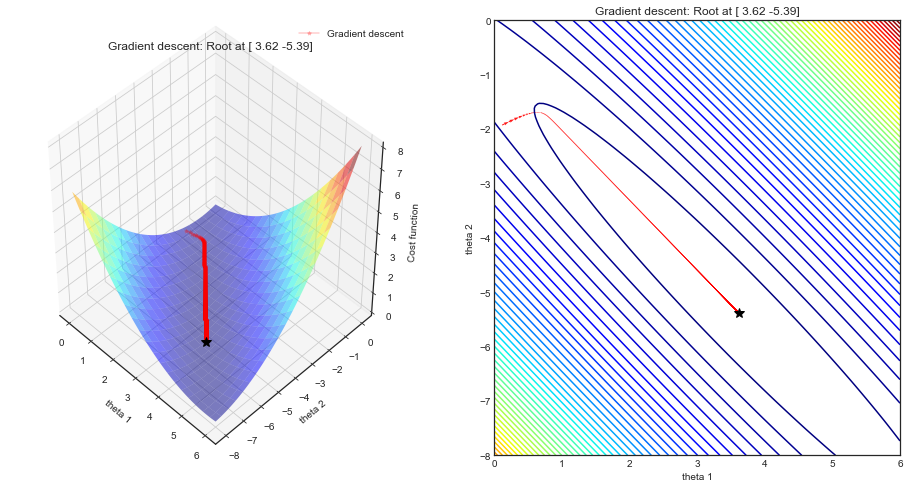

In [16]:
#Creating the dataset (as previously)

X = X_d.values

#Setup of meshgrid of theta values
T0, T1 = np.meshgrid(np.linspace(0,6,100),np.linspace(0,-8,100))

#Computing the cost function for each theta combination
zs = np.array(  [costfunction(np.array([t0,t1]).reshape(-1,1), X, y_noise.reshape(-1,1)) 
                     for t0, t1 in zip(np.ravel(T0), np.ravel(T1)) ] )
#Reshaping the cost values    
Z = zs.reshape(T0.shape)


#Computing the gradient descent
theta_result,J_history, count_history_1, theta_1, theta_2 = gradient_descent(initial_theta,X,y_noise,alpha = 0.3,num_iters=5000)


#Angles needed for quiver plot
anglesx = np.array(theta_1)[1:] - np.array(theta_1)[:-1]
anglesy = np.array(theta_2)[1:] - np.array(theta_2)[:-1]

%matplotlib inline
fig = plt.figure(figsize = (16,8))

#Surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(T0, T1, Z, rstride = 5, cstride = 5, cmap = 'jet', alpha=0.5)
ax.plot(theta_1,theta_2,J_history, marker = '*',markersize = 4, color = 'r', alpha = .2, label = 'Gradient descent')
ax.plot(coefs[0],coefs[1], marker = '*', color = 'black', markersize = 10)

ax.set_xlabel('theta 1')
ax.set_ylabel('theta 2')
ax.set_zlabel('Cost function')
ax.set_title('Gradient descent: Root at {}'.format(theta_calc.flatten().round(2)))
ax.view_init(45, -45)
ax.legend()


#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(T0, T1, Z, 70, cmap = 'jet')
ax.quiver(theta_1[:-1], theta_2[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .9)
ax.plot(coefs[0],coefs[1], marker = '*', color = 'black', markersize = 10)
ax.set_xlabel('theta 1')
ax.set_ylabel('theta 2')
ax.set_title('Gradient descent: Root at {}'.format(theta_calc.flatten().round(2)))
ax.legend()

plt.legend()
plt.show()


### Sciy optimize fit

In [17]:
import scipy.optimize as opt

theta_init = np.ones((len(X_d.T),1)).reshape(-1,1)
model_t = opt.minimize(fun = costfunction, x0 = theta_init , args = (X_d, y_noise), 
                             method = 'dogleg', jac = grad, hess= hessian, options={'maxiter':1000})
model_t.x

array([ 3.62016596, -5.38895073])

### Sklearn fit 

In [18]:
from sklearn import linear_model
model_d = linear_model.LinearRegression(fit_intercept=False)
model_d.fit(X_d,y_noise)
model_d.coef_

array([[ 3.62016596, -5.38895073]])

### Statsmodel fit 

In [19]:
import statsmodels.api as sm
model_sm = sm.OLS(y_noise, X_d)
res = model_sm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     107.3
Date:                Thu, 07 Jun 2018   Prob (F-statistic):           2.33e-16
Time:                        10:22:03   Log-Likelihood:                -8.0664
No. Observations:                  40   AIC:                             20.13
Df Residuals:                      38   BIC:                             23.51
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X1             3.6202      0.316     11.466      0.0